In [1]:
import json
import os
from binance.client import Client

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/uknowit/Binance')

with open('api_key.json') as json_file:
    api_stuff = json.load(json_file)

KEY = api_stuff['api_key']
SECRET = api_stuff['secret'] 

In [2]:
client = Client(KEY, SECRET, {"verify": False, "timeout": 20})


In [15]:

def simulate_profit(df, quantity = 1):
    return quantity * df.close * df.cross

class Klines():
    def __init__(self, klines_list):
        self.list = klines_list
        self.dict = self.to_dict(self.list)
        self.df = self.to_df(self.list)
        self.close_df = self.df_MA_close()
        self.profit = self.MA_close_profit()
       
    
    def to_dict(self, klines):
        ''' Creates a dict of dicts with the kline key = open_time of the kline'''

        kline_dict = dict()
        for kline in klines:
            kline_to_add = {
                kline[0]: {
                    "open_time": kline[0],
                    "open": kline[1],
                    "high": kline[2],
                    "low": kline[3],
                    "close": kline[4],
                    "volume": kline[5],
                    "close_time": kline[6],
                    "quote_asset_volume": kline[7],
                    "no_of_trades": kline[8],
                    "taker_buy_base_asset_volume": kline[9],
                    "taker_buy_quote_asset_volume": kline[10],
                }
            }
            kline_dict.update(kline_to_add)
        return kline_dict

    def to_df(self, klines):
        kline_columns = [
                "open_time",
                "open",
                "high",
                "low",
                "close",
                "volume",
                "close_time",
                "quote_asset_volume",
                "no_of_trades",
                "taker_buy_base_asset_volume",
                "taker_buy_quote_asset_volume",
                "ignore"
                ]
        df = pd.DataFrame(klines, columns = kline_columns)
        df = df.apply(pd.to_numeric, errors = 'coerce')
        df["open_time"] = pd.to_datetime(df.open_time, unit='ms')
        df["close_time"]= pd.to_datetime(df.close_time, unit = 'ms')
        df.drop(columns=["ignore","taker_buy_base_asset_volume","taker_buy_quote_asset_volume"], inplace = True)
        df.index = df.open_time
        return df
    
    def df_MA_close(self, time_interval = [5,40]):
        df = self.df
        closing_MA_s = df["close"].rolling(time_interval[0], min_periods=time_interval[0]).mean()
        closing_MA_l = df["close"].rolling(time_interval[1], min_periods= time_interval[1]).mean()
        df["ma_s"] = closing_MA_s
        df["ma_l"] = closing_MA_l
        
        close_df = df[["close", "ma_s", "ma_l"]]
        
        return close_df
    
    def MA_close_profit(self):
        try:
            df = self.close_df
        except:
            print("no close_df found")
            return
        
        # Positive value indicates buy signal, negative indicates sell
        cross = ((df.ma_s - df.ma_l > 0)).astype(int) - (df.ma_s.shift(1) - df.ma_l.shift(1) >0).astype(int)
        # Do not buy or sell first and last period
        cross[0], cross[-1] = (0, 0)
        
        self.df["cross"] = cross
        
        orders = self.df.apply(simulate_profit, axis = 1)
        
        self.df["orders"] = orders
        
        absolute_profit = cross.sum()*self.close_df.close[-1] - orders.sum()
        percent_return = absolute_profit / self.close_df.close[-1]
        
        return (absolute_profit, percent_return)
    

In [16]:
klines_dict = dict()

symbols = ["DOGEUSDT", "ETHUSDT", "BTCUSDT", "ETCUSDT", "BCHUSDT", "XRPUSDT", "LTCUSDT"]
for symbol in symbols:
    klines = Klines(client.futures_klines(symbol = symbol, interval = client.KLINE_INTERVAL_1HOUR, limit = 1000))
    klines_dict.update({symbol : klines})
   

In [17]:

for symbol in klines_dict:
    print(klines_dict.get(symbol).profit, symbol)
    

(0.03163600000000001, 0.6941068059151347) DOGEUSDT
(669.0500000000002, 0.38025439334348793) ETHUSDT
(10864.389999999978, 0.2848008719878612) BTCUSDT
(1.1970000000000045, 0.14595781002316843) ETCUSDT
(115.62999999999965, 0.26123988974741236) BCHUSDT
(0.21609999999999993, 0.4662351672060408) XRPUSDT
(-16.389999999999986, -0.10473512684516573) LTCUSDT


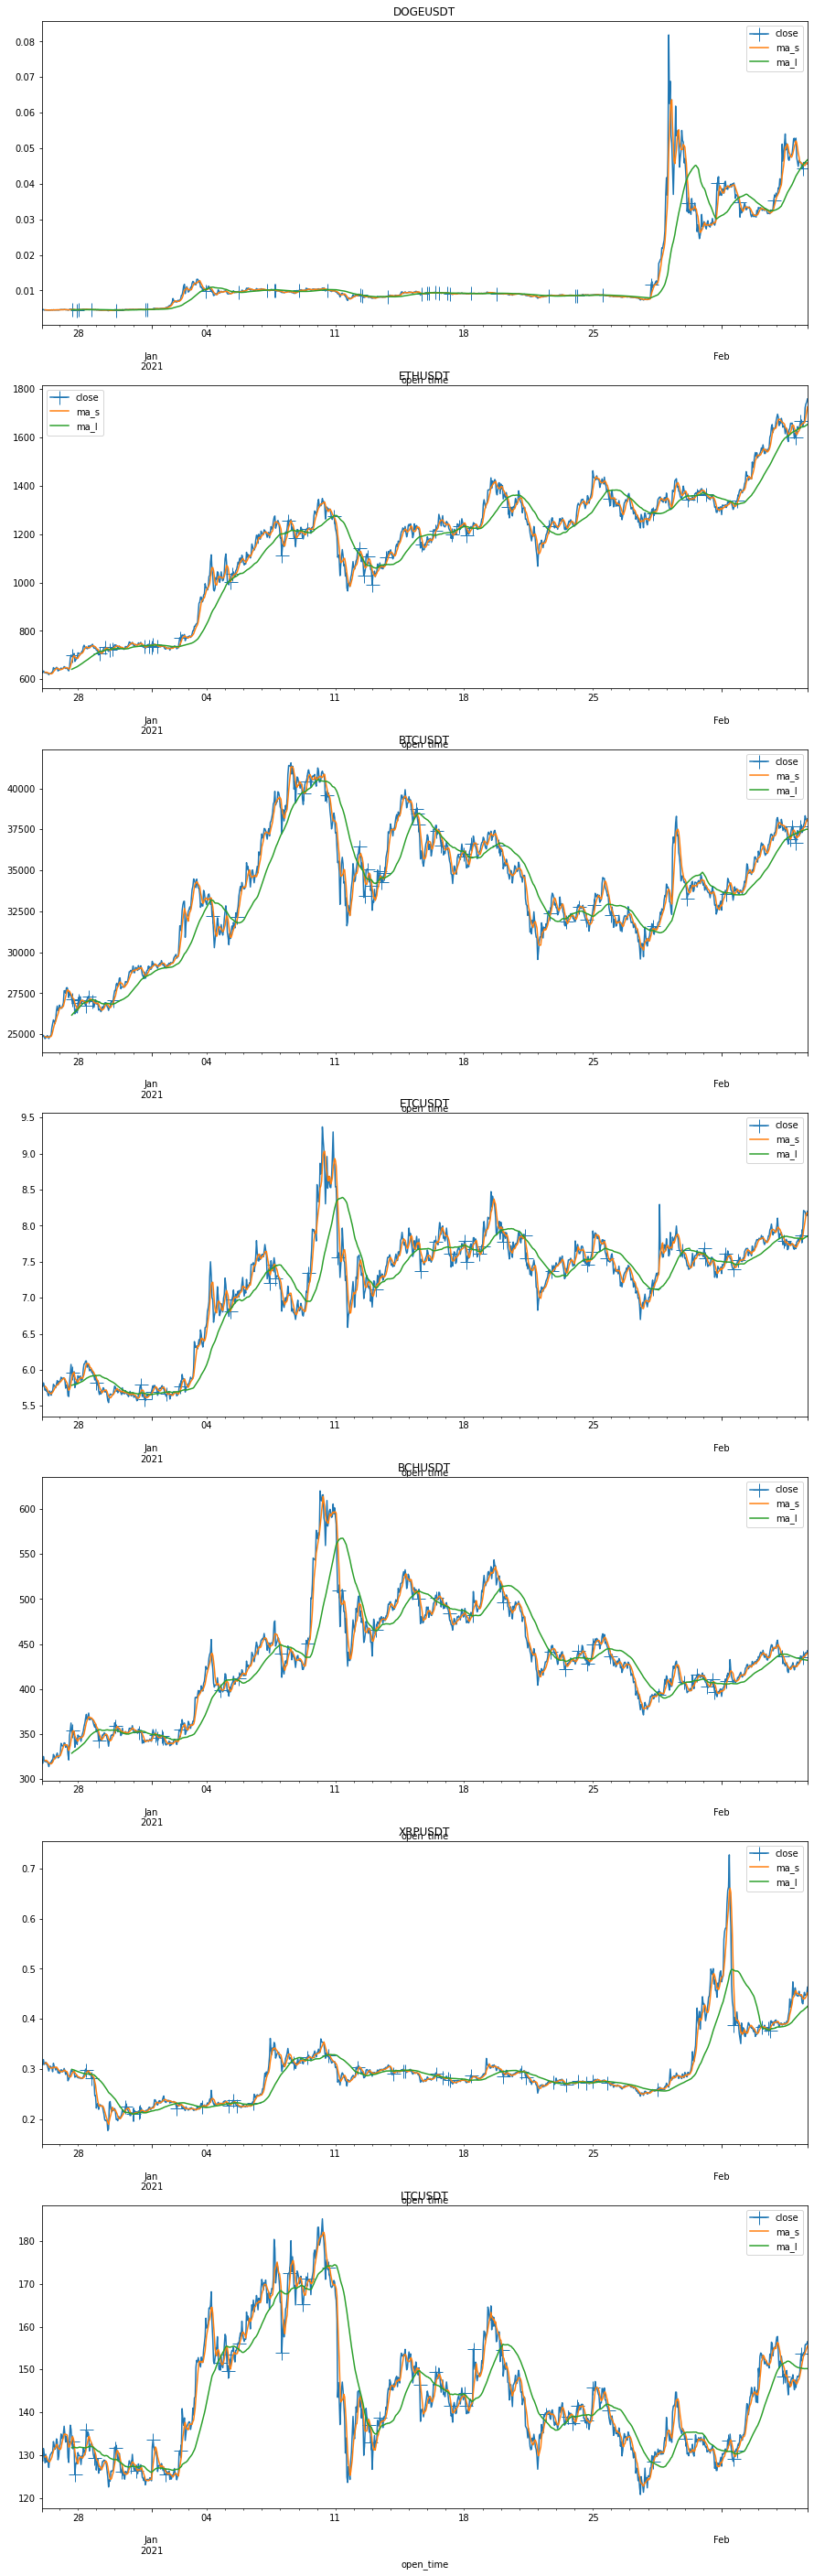

In [18]:
import matplotlib.pyplot as plt



fig, axes = plt.subplots(nrows=len(klines_dict), ncols=1)
for i, symbol in enumerate(klines_dict):
    markers = list(klines_dict.get(symbol).df.cross.astype(bool))
    klines_dict.get(symbol).close_df.plot(markevery=markers, ax=axes[i], title = symbol, 
                                          style = ['+-', '-', '-'], figsize = (15,50), markersize =15)


In [19]:
# Merge dfs to predict ETH prices based on other cryptos

combined_df = klines_dict.get('ETHUSDT').close_df.copy(deep=True)

for symbol in klines_dict:
    if symbol == 'ETHUSDT':
        continue  
    column_name = f"{symbol}_close"
    combined_df[column_name] = klines_dict.get(symbol).close_df.close

combined_df

,close,ma_s,ma_l,DOGEUSDT_close,BTCUSDT_close,ETCUSDT_close,BCHUSDT_close,XRPUSDT_close,LTCUSDT_close
open_time,,,,,,,,,
2020-12-26 01:00:00,628.02,NaN,NaN,0.004558,24928.28,5.772,321.04,0.3090,129.18
2020-12-26 02:00:00,626.62,NaN,NaN,0.004557,24858.51,5.768,317.30,0.3086,128.62
2020-12-26 03:00:00,634.45,NaN,NaN,0.004646,24931.98,5.820,325.00,0.3192,131.57
2020-12-26 04:00:00,630.70,NaN,NaN,0.004471,24832.95,5.784,320.53,0.3096,130.36
2020-12-26 05:00:00,626.79,629.316,NaN,0.004520,24729.55,5.719,319.24,0.3114,128.23
...,...,...,...,...,...,...,...,...,...
2021-02-05 12:00:00,1663.37,1660.684,1645.19450,0.045702,37916.26,8.202,436.70,0.4530,153.34
2021-02-05 13:00:00,1723.65,1670.884,1647.40100,0.045777,38333.60,8.193,440.12,0.4475,155.71
2021-02-05 14:00:00,1738.94,1687.750,1649.90700,0.046162,38138.52,8.145,440.28,0.4475,155.92


In [20]:
from scipy import stats
import statsmodels.api as sm

print(sm.tsa.stattools.adfuller(combined_df.close))

(-0.8922554267016359, 0.7905121166039665, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 8554.354112782587)


In [63]:
# Let's create a seasonal shift of 24 hours and then difference to get a SARIMA
df = combined_df.copy(deep=True)
df.drop(columns = ['ma_s', 'ma_l', 'close_1D', 'close_1Ds'], inplace=True)

for column in df.columns.copy():
    a = df[column].shift(1, freq = 'D')
    name = f"{column}_1D"
    seasonal_diff = df.close - a
    df[name] = seasonal_diff - seasonal_diff.shift(1)

df

,close,DOGEUSDT_close,BTCUSDT_close,ETCUSDT_close,BCHUSDT_close,XRPUSDT_close,LTCUSDT_close,close_1D,DOGEUSDT_close_1D,BTCUSDT_close_1D,ETCUSDT_close_1D,BCHUSDT_close_1D,XRPUSDT_close_1D,LTCUSDT_close_1D
open_time,,,,,,,,,,,,,,
2020-12-26 01:00:00,628.02,0.004558,24928.28,5.772,321.04,0.3090,129.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 02:00:00,626.62,0.004557,24858.51,5.768,317.30,0.3086,128.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 03:00:00,634.45,0.004646,24931.98,5.820,325.00,0.3192,131.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 04:00:00,630.70,0.004471,24832.95,5.784,320.53,0.3096,130.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 05:00:00,626.79,0.004520,24729.55,5.719,319.24,0.3114,128.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-05 12:00:00,1663.37,0.045702,37916.26,8.202,436.70,0.4530,153.34,-25.57,-2.195513,-308.39,-2.290,-5.05,-2.2021,-4.20
2021-02-05 13:00:00,1723.65,0.045777,38333.60,8.193,440.12,0.4475,155.71,64.37,60.278272,92.23,60.296,59.66,60.2759,59.42
2021-02-05 14:00:00,1738.94,0.046162,38138.52,8.145,440.28,0.4475,155.92,55.29,15.291552,810.68,15.418,24.48,15.2931,18.97


In [40]:
# Note that the slice of 25: is essential due to the seasonal differencing and first difference, which removes 25 observations
print(sm.tsa.stattools.adfuller(df.close_1D[25:]))

(-22.722599123090514, 0.0, 1, 973, {'1%': -3.4370885772879083, '5%': -2.8645150193044464, '10%': -2.5683540564723377}, 9034.680513924533)
['close', 'DOGEUSDT_close', 'BTCUSDT_close', 'ETCUSDT_close', 'BCHUSDT_close', 'XRPUSDT_close', 'LTCUSDT_close', 'close_1D', 'DOGEUSDT_close_1D', 'BTCUSDT_close_1D', 'ETCUSDT_close_1D', 'BCHUSDT_close_1D', 'XRPUSDT_close_1D', 'LTCUSDT_close_1D']


In [64]:
import pmdarima as pm

# SARIMAX Model
exog_symbols = []
for c in df.columns:
    if 'USDT_close_1D' in c:
        exog_symbols.append(c)

        
sxmodel = pm.auto_arima(df[['close_1D']][25:], exogenous=df[exog_symbols][25:],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7862.269, Time=0.85 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7594.221, Time=9.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7860.270, Time=2.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7863.264, Time=1.38 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=7499.213, Time=19.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=18.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=7497.926, Time=29.50 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=7593.415, Time=6.69 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=16.88 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.00 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=7499.099, Time=18.69 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=7

In [65]:
# Great results, but obviously unfeasible to have exogenous at time of prediction, only have the lagged observations
# I will rerun with lagged other coins instead.
sxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  975
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3738.980
Date:                  Fri, 05 Feb 2021   AIC                           7495.961
Time:                          19:06:18   BIC                           7539.791
Sample:                      12-27-2020   HQIC                          7512.650
                           - 02-05-2021                                         
Covariance Type:                    opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DOGEUSDT_close_1D    25.0119     44.950      0.556      0.578     -63.089     113.113
BTCUSDT_close_1D      0.0147      0.001     17.114      0.000       0.013       0.016
ETCUSDT_close_1D     39.1636      2.321     16.870      0.000      34.614      43.714
BCHUSDT_close_1D      0.1361      0.069      1.986      0.047       0.002       0.270
XRPUSDT_close_1D    -66.0420     44.946     -1.469      0.142    -154.135      22.051
LTCUSDT_close_1D      2.7668      0.197     14.056      0.000       2.381       3.153
ar.S.L12             -0.6596      0.028    -23.347      0.000      -0.715      -0.604
ar.S.L24             -0.3294      0.028    -11.765      0.000      -0.384      -0.275
sigma2              137.0667      4.163     32.924      0.000     128.907     145.226
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):               347.65
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.17
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# Ugly trick to get the model to only 'see' what its supposed to see. Information available at time t is exogenous at
# t-1, so used 25:-1 in y slice and [26:] in exogenous slice. For example at time period t=1, y is regressed on x at t=0.
sxmodel2 = pm.auto_arima(df[['close_1D']][25:-1], exogenous=df[exog_symbols][26:],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7852.228, Time=0.58 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7583.824, Time=6.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7850.231, Time=1.35 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7853.143, Time=1.43 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=7488.655, Time=18.51 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=25.32 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.72 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=7487.291, Time=24.81 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=7582.874, Time=13.92 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=15.57 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=7488.556, Time=18.42 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=

In [70]:
sxmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  974
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3733.765
Date:                  Fri, 05 Feb 2021   AIC                           7485.529
Time:                          19:22:59   BIC                           7529.350
Sample:                      12-27-2020   HQIC                          7502.215
                           - 02-05-2021                                         
Covariance Type:                    opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DOGEUSDT_close_1D    25.8757     45.748      0.566      0.572     -63.789     115.540
BTCUSDT_close_1D      0.0148      0.001     16.944      0.000       0.013       0.016
ETCUSDT_close_1D     39.2407      2.361     16.621      0.000      34.613      43.868
BCHUSDT_close_1D      0.1397      0.069      2.010      0.044       0.003       0.276
XRPUSDT_close_1D    -66.9444     45.744     -1.463      0.143    -156.600      22.711
LTCUSDT_close_1D      2.7244      0.201     13.557      0.000       2.331       3.118
ar.S.L12             -0.6588      0.029    -22.943      0.000      -0.715      -0.603
ar.S.L24             -0.3289      0.028    -11.549      0.000      -0.385      -0.273
sigma2              139.4654      4.313     32.339      0.000     131.013     147.918
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               354.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.17
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""